# Naïve (Weekly & Daily) Baselines 

**Goal:**  

Utilize two Naïve Baselines (Weekly & Daily) model to forecast the daily german electricity consumption in 2019 
 - Evaluation type: Offline / historical backtest  
 - Metric focus: MAE, RMSE, MAP 

**MLflow server:** 

mlflow server --backend-store-uri sqlite:///mlflow.db --host 127.0.0.1 --port 8080

**Author:** Rodrigo Amorim


## Import the necessary libraries and load the dataset

In [1]:
# Import the required libraries 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import mlflow

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set the tracking uri and give a name to the experiment (MLflow set up)
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Naïve_EnergyPrediction_Exp")

2025/12/23 14:13:34 INFO mlflow.tracking.fluent: Experiment with name 'Naïve_EnergyPrediction_Exp' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/1', creation_time=1766499214672, experiment_id='1', last_update_time=1766499214672, lifecycle_stage='active', name='Naïve_EnergyPrediction_Exp', tags={}>

In [4]:
# Import the processed dataset
df = pd.read_parquet(r'C:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\Data\Processed/GermanEnergyConsumption.parquet')
df.head()

,DE_Load
Date,
2015-01-01 00:00:00+01:00,42424.0
2015-01-01 01:00:00+01:00,41151.0
2015-01-01 02:00:00+01:00,40135.0
2015-01-01 03:00:00+01:00,39106.0
2015-01-01 04:00:00+01:00,38765.0


In [ ]:
# Train/Test Split 
# We will evaluate the model by predicting the next 24 hours repeatedly across the whole 2019 year (rolling-origin evaluation)
# Train (years) -> 2015/2016/2017/2018
# Test (years)  -> 2019

# Create a dataframe for testing 
test = df[df.index >= "2019"]

# Define the true values 
y_true = test["DE_Load"]

# Horizon of prediction 
Horizon = 24 

# Timestamps for the plots  
df2 = df.reset_index()
df2 = df2[df2["Date"] >= "2019"]
timestamps = df2["Date"].values

## Create the daily and weekly baselines 

In [6]:
# Weekly Naïve Baseline (Leverages Weekly seasonality)

def naive_weekly(test, Horizon):
    
    pred_weekly = []

    for start in test.index[::Horizon]:

        end = start + pd.Timedelta(hours = Horizon)
        
        # Select the previous week values 
        prediction = df.loc[start - pd.Timedelta(days = 7) : end - pd.Timedelta(days = 7) - pd.Timedelta(hours = 1), "DE_Load"] 
        
        # Check for missing data
        if len(prediction) != Horizon:
            raise ValueError(f"Missing data at {start}")

        pred_weekly.extend(prediction.values)


    return np.array(pred_weekly)

In [7]:
# Daily Naïve Baseline (Leverages daily seasonality)

def naive_daily(test, Horizon):

    pred_daily = []

    for start in test.index[::Horizon]:

        end = start + pd.Timedelta(hours = Horizon)

        prediction = df.loc[start - pd.Timedelta(days = 1) : end - pd.Timedelta (days = 1) - pd.Timedelta (hours = 1), "DE_Load"]

        if len(prediction) != Horizon:
            raise ValueError(f"Missing data at {start}")

        pred_daily.extend(prediction.values)

    return np.array(pred_daily)    

## Make the predictions and compute the performance metrics 

In [ ]:
# Make the predictions 
y_pred_weekly = naive_weekly(test, Horizon)
y_pred_daily = naive_daily(test, Horizon)

In [9]:
# Compute the  Weekly Naïve baseline performance metrics 
mae = mean_absolute_error(y_true, y_pred_weekly)
rmse = root_mean_squared_error(y_true, y_pred_weekly)
map = mean_absolute_percentage_error(y_true, y_pred_weekly)

print("Perfomance Metrics for the Weekly Naïve baseline:\n")
print(f"Rolling 24h MAE (full year): {mae:.2f}")
print(f"Rolling 24h RMSE (full year): {rmse: .2f}")
print(f"Rolling 24h MAP (full year): {map: .2f}")

print("--------------------------------------------------")

print("Perfomance Metrics for the Daily Naïve baseline:\n")
# Compute the  Daily Naïve baseline performance metrics 
mae = mean_absolute_error(y_true, y_pred_daily)
rmse = root_mean_squared_error(y_true, y_pred_daily)
map = mean_absolute_percentage_error(y_true, y_pred_daily)

print(f"Rolling 24h MAE (full year): {mae:.2f}")
print(f"Rolling 24h RMSE (full year): {rmse: .2f}")
print(f"Rolling 24h MAP (full year): {map: .2f}")

Perfomance Metrics for the Weekly Naïve baseline:

Rolling 24h MAE (full year): 2558.00
Rolling 24h RMSE (full year):  4464.94
Rolling 24h MAP (full year):  0.05
--------------------------------------------------
Perfomance Metrics for the Daily Naïve baseline:

Rolling 24h MAE (full year): 4557.51
Rolling 24h RMSE (full year):  6943.97
Rolling 24h MAP (full year):  0.08


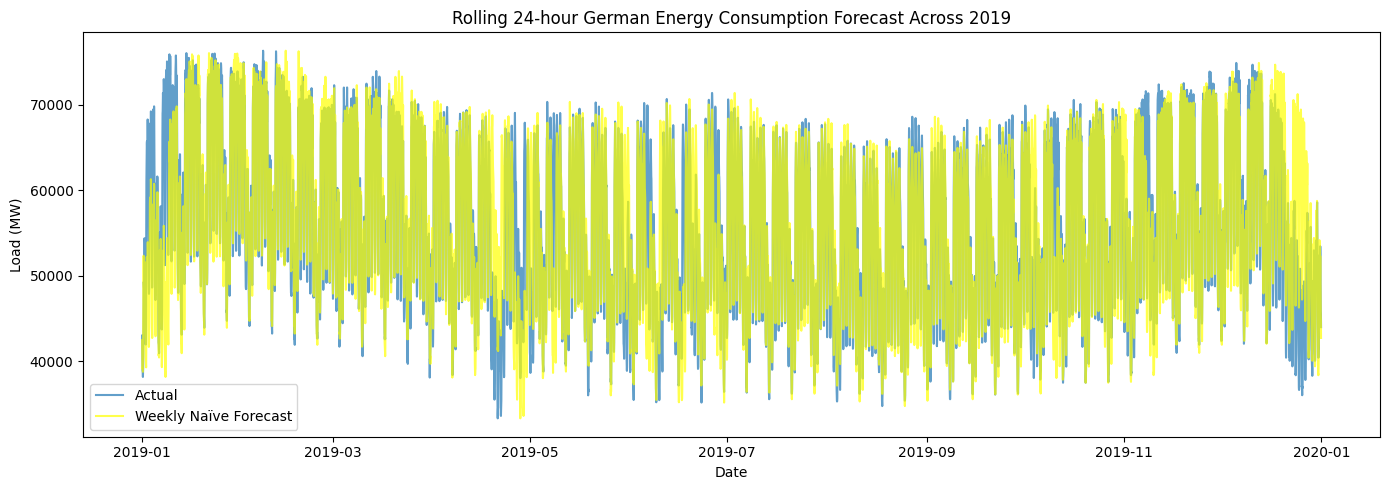

In [ ]:
# Plot the forecast predictions from the Weekly Naïve
plt.figure(figsize=(14, 5))
plt.plot(timestamps, y_true, label="Actual", alpha=0.7)
plt.plot( timestamps, y_pred_weekly, label="Weekly Naïve Forecast", alpha=0.7, color = "yellow")
plt.legend()
plt.title("Rolling 24-hour German Energy Consumption Forecast Across 2019")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.show()

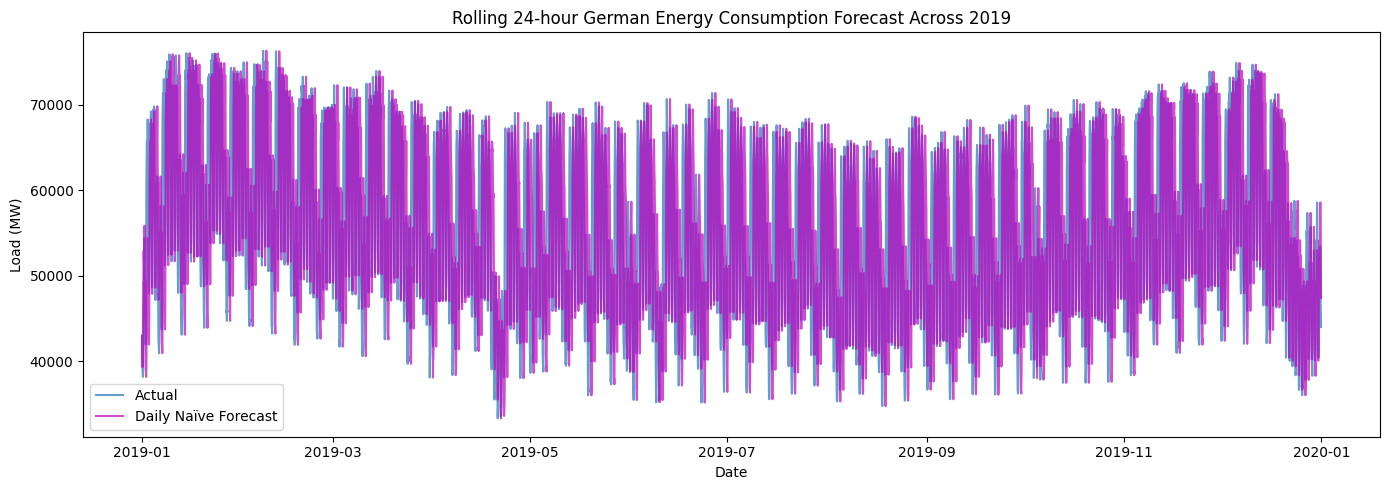

In [ ]:
# Plot the forecast predictions from the Daily Naïve
plt.figure(figsize=(14, 5))
plt.plot(timestamps, y_true, label="Actual", alpha=0.7)
plt.plot(timestamps, y_pred_daily, label="Daily Naïve Forecast", alpha=0.7, color = "m")
plt.legend()
plt.title("Rolling 24-hour German Energy Consumption Forecast Across 2019")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.tight_layout()
plt.show()

In [13]:
# Save the results into mlflow 
with mlflow.start_run(run_name = "Naïve_Results"):

    # Save the data first 
    np.save("y_pred_daily.npy", y_pred_daily)
    np.save("y_pred_weekly.npy", y_pred_weekly)
    np.save("y_true.npy", y_true)

    mlflow.log_artifact("y_pred_daily.npy")   
    mlflow.log_artifact("y_pred_weekly.npy")
    mlflow.log_artifact("y_true.npy")
    

🏃 View run Naïve_Results at: http://127.0.0.1:8080/#/experiments/1/runs/c1d85a249d1e4fd09dca9f5a7fcab3f1
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/1
